Another MCMC algorithm provided by tfp is **Hamiltonian Monte Carlo (HMC)**


UnlikeMetropolis-Hastings where steps are taken in a random direction, HMC makes use of the gradients
of the likelihood to move towards more likely parameters. This means that HMC can be faster to converge
to the target distribution and often requires less time to run.


We’ll implement HMC on the lions and wildebeest data we used earlier.

In [1]:
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [2]:
# numpy arrays for the observations
ldata = np.array([0, 2, 1, 1, 2, 3, 6, 4, 5, 6, 7, 2, 0, 6, 5, 6, 2, 1, 6, 5])
wdata = np.array([64, 0, 16, 14, 3, 1, 0, 0, 0, 0, 0, 1, 58, 0, 0, 0, 6, 10, 0, 0])

# log likelihood as a function of alpha
def log_likelihood_lions(alpha):
    joint = tfd.JointDistributionSequential([tfd.Poisson(rate=1,name='lions'),
    lambda lions : tfd.Poisson(rate=tf.exp(4-alpha*lions),name='wildebeest')
    ])
    
    # return a single log likelihood for all the observations
    total_log_likelihood = tf.reduce_sum(joint.log_prob([ldata,wdata]))
    return total_log_likelihood

    
#Now, we’ll set-up the HMC sampler and take 2000 samples
@tf.function
def run_hmc_sampler():
    # create the kernel
    kernel = tfp.mcmc.HamiltonianMonteCarlo(log_likelihood_lions,
                                            step_size=0.05,
                                            num_leapfrog_steps=10)
    # sample from the chain
    samples, kernels_results = tfp.mcmc.sample_chain(num_results=2000,
                                            current_state=0.5,
                                            kernel=kernel,
                                            num_burnin_steps=50)
    return samples

    
# run the sampler
s_hmc = run_hmc_sampler()


print(tfp.mcmc.effective_sample_size(s_hmc).numpy())


/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:70: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(


Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


2023-07-24 15:56:39.473489: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 15:56:39.988913: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10294 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7
/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


1077.8829


Now we’ll compare to the MH sampler with the same number of samples

In [4]:
@tf.function
def run_mh_sampler():
    # create the kernel
    kernel = tfp.mcmc.RandomWalkMetropolis(log_likelihood_lions)
    # sample from the chain
    samples, kernels_results = tfp.mcmc.sample_chain(num_results=2000,
                                                current_state=0.5,
                                                kernel=kernel,
                                                num_burnin_steps=50)
    return samples
    
# run the sampler
s_mh = run_mh_sampler()
print(tfp.mcmc.effective_sample_size(s_mh).numpy())

/opt/conda/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


146.77693


Notice how we obtained far more effective samples from the HMC sampler. This is because the sampler
can make use of the gradients to move around the distribution more easily.


Finally, we’ll plot the posterior distribution using the HMC sampler along with the known true value for
𝛼.

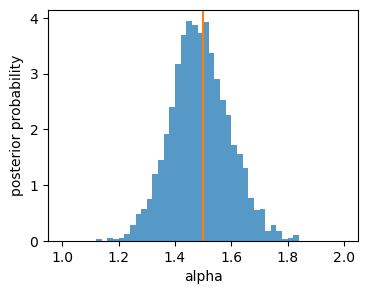

In [5]:
plt.figure(figsize=(4,3))
plt.hist(s_hmc.numpy(),bins=50,range=(1,2),density=True,alpha=0.75)

plt.axvline(1.5,c='C1')
plt.xlabel('alpha')
plt.ylabel('posterior probability')
plt.show()